In [1]:
import os
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

yf.pdr_override()

pd.set_option('chained_assignment',None)

In [2]:
today = dt.datetime.today()
last_month = dt.datetime.today() - dt.timedelta(days=30)
year = today.year - 1

# list of financial parametrs in ticker data object that I care about
financials_list = ['previousClose','marketCap','trailingPE','forwardPE','priceToBook',
                   'pegRatio','forwardEps','beta','shortPercentOfFloat','shortRatio',
                  'bookValue']

In [55]:
def price_to_sales(ticker): # calculate price to sales ratio based on market cap and TTM reveunue
    # convert CNY to USD if company is based in China, double check Yahoo Finance to confirm currency revenue is reported in
    sales_usd = 0
    if ticker.info['country'] == 'China':
        cny = pdr.FredReader("DEXCHUS",start=last_month,end=today).read()
        cny_to_usd = cny['DEXCHUS'].mean()
        sales_usd = ticker.quarterly_earnings['Revenue'].sum() / cny_to_usd
    # skip straight to p / s calc if not from China
    else:
        sales_usd = ticker.quarterly_earnings['Revenue'].sum()
    return ticker.info['marketCap'] / sales_usd

def return_on_equity(ticker): # calculate shareholder return on equity based on book value and TTM reveunue
    # convert CNY to USD if company is based in China, double check Yahoo Finance to confirm currency revenue is reported in
    sales_usd = 0
    if ticker.info['country'] == 'China':
        cny = pdr.FredReader("DEXCHUS",start=last_month,end=today).read()
        cny_to_usd = cny['DEXCHUS'].mean()
        earnings_usd = ticker.quarterly_earnings['Earnings'].sum() / cny_to_usd
    # skip straight to p / s calc if not from China
    else:
        earnings_usd = ticker.quarterly_earnings['Earnings'].sum()
    
    try:
        return earnings_usd / ticker.info['bookValue']
    
    except:
        return 0.0
    

def make_data_frame(company_names, financials_list):
    # pull raw data form yahoo finance
    raw_yfin_data = yf.Tickers(company_names)
    df = pd.DataFrame(index=raw_yfin_data.symbols,columns=financials_list)
    for stock in df.index:
        # build dataframe from the parameters I care about
        for data in financials_list:
            try:
                df[data][stock] = raw_yfin_data.tickers[stock].info[data]
            except:
                df[data][stock] = 0.0
            
        df.loc[stock, 'pricetoSales'] = price_to_sales(raw_yfin_data.tickers[stock])
        df.loc[stock, 'returnonEquity'] = return_on_equity(raw_yfin_data.tickers[stock])


    return df

In [56]:
# inputs for sectors and tickers to track
sectors = {
    'ev' : ['TSLA','NIO','F'],
    'fintech' : ['SQ','LMND','PYPL','RKT','PINS','Z','JPM','MET','ALL'],
    'bio'  : ['PACB','TDOC','CDNA'],
    'tech' : ['FB', 'AAPL', 'GOOG', 'AMZN', 'TWTR'],
    'auto' : ['CVNA','SFT','VRM'],
    're' : ['ZG','RDFN','OPEN']
}

In [57]:
ev_df, fintech_df, bio_df, tech_df, auto_df, re_df = [ make_data_frame(sectors[sector],financials_list) for sector in sectors ]

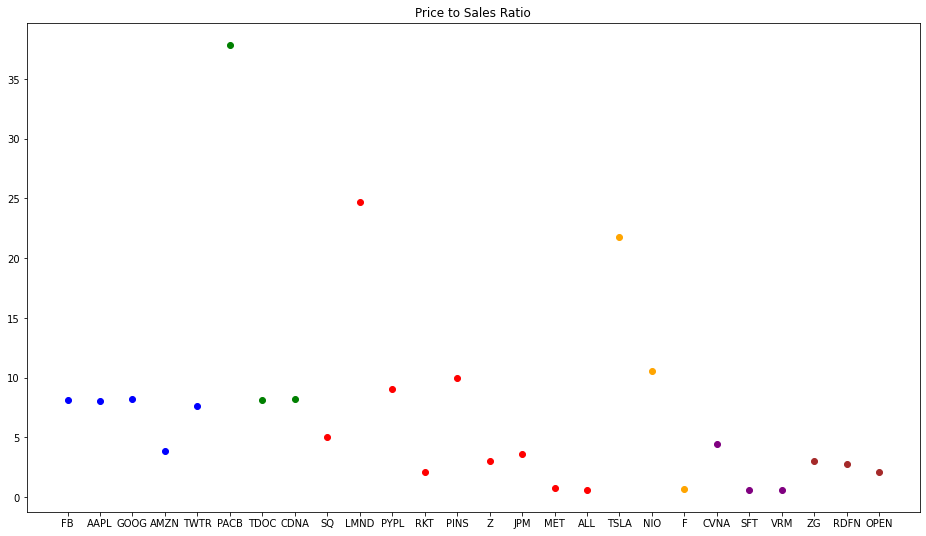

In [59]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(tech_df.index, tech_df['pricetoSales'], facecolor='blue')
ax.scatter(bio_df.index, bio_df['pricetoSales'], facecolor='green')
ax.scatter(fintech_df.index, fintech_df['pricetoSales'], facecolor='red')
ax.scatter(ev_df.index, ev_df['pricetoSales'], facecolor='orange')
ax.scatter(auto_df.index, auto_df['pricetoSales'], facecolor='purple')
ax.scatter(re_df.index,re_df['pricetoSales'], facecolor='brown')
plt.title('Price to Sales Ratio')
plt.show()

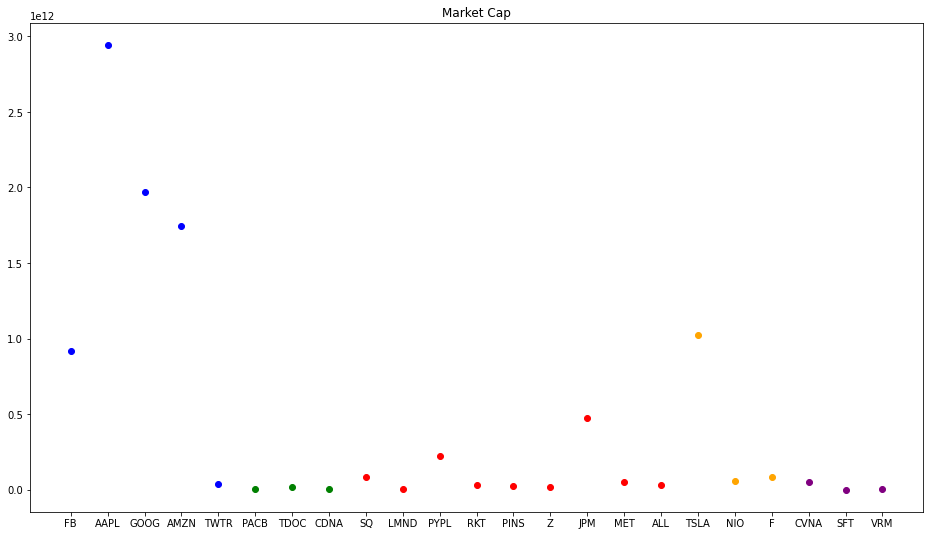

In [60]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(tech_df.index, tech_df['marketCap'], facecolor='blue')
ax.scatter(bio_df.index, bio_df['marketCap'], facecolor='green')
ax.scatter(fintech_df.index, fintech_df['marketCap'], facecolor='red')
ax.scatter(ev_df.index, ev_df['marketCap'], facecolor='orange')
ax.scatter(auto_df.index, auto_df['marketCap'], facecolor='purple')
plt.title('Market Cap')
plt.show()

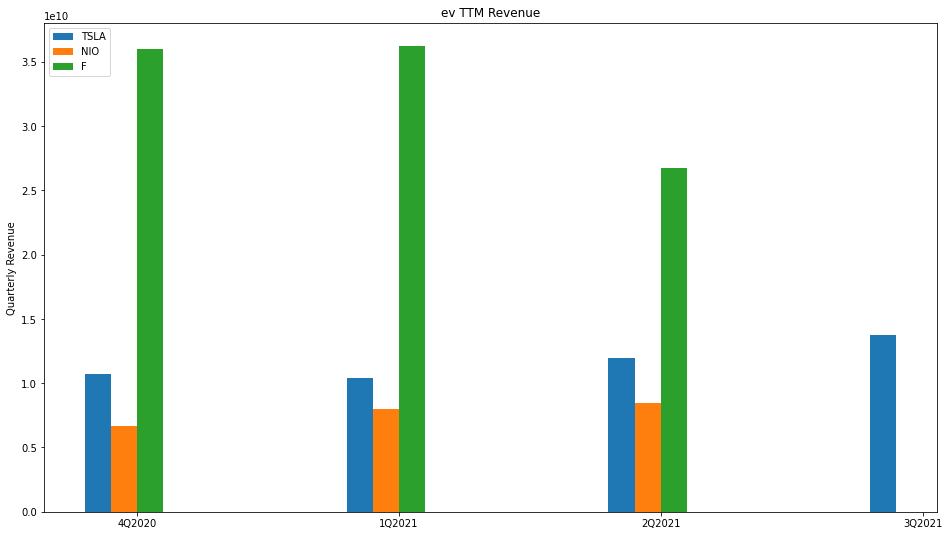

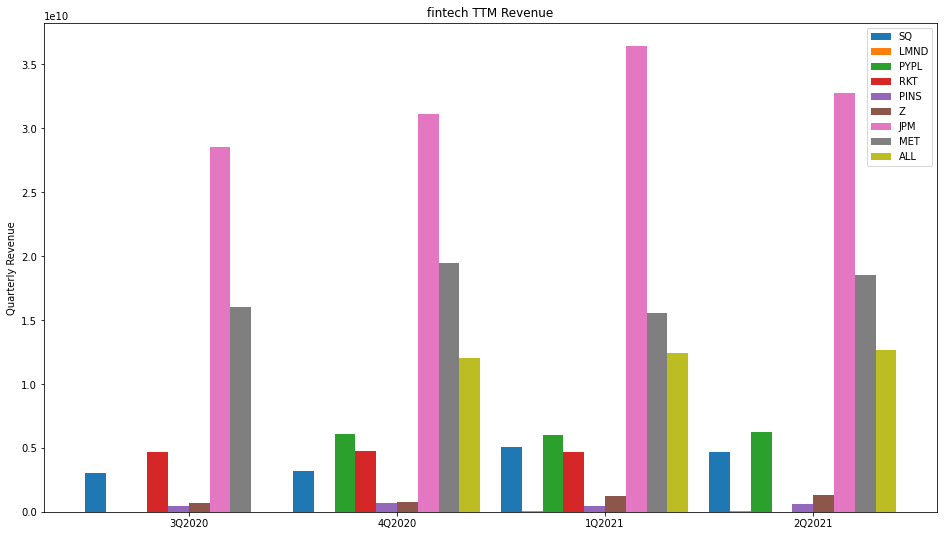

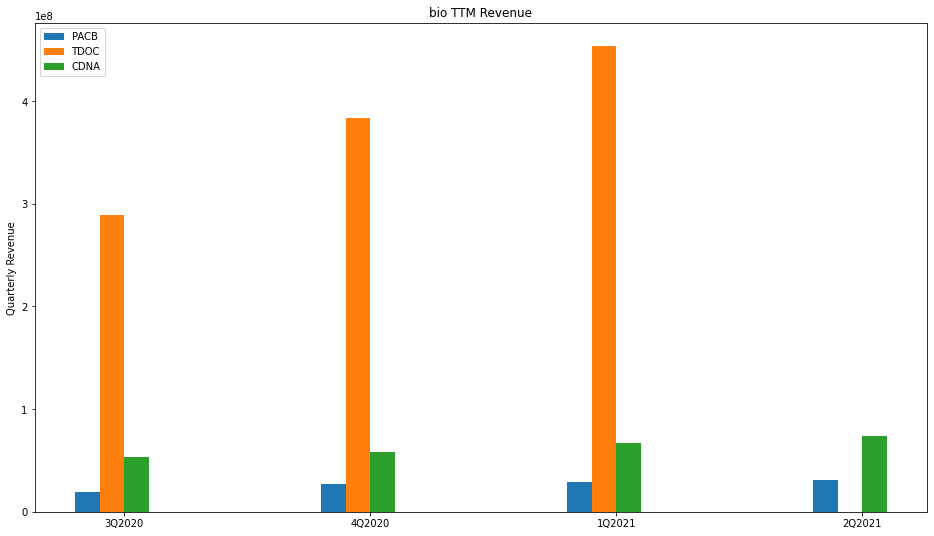

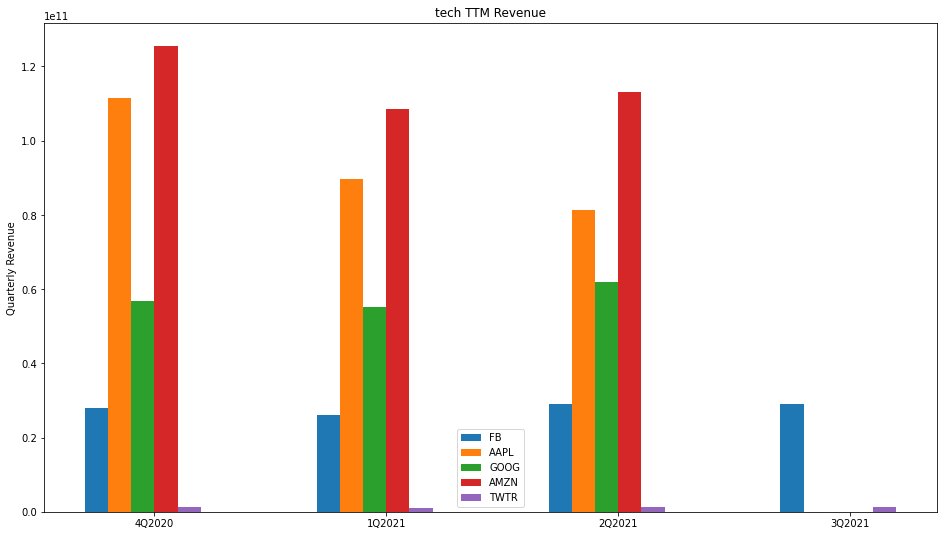

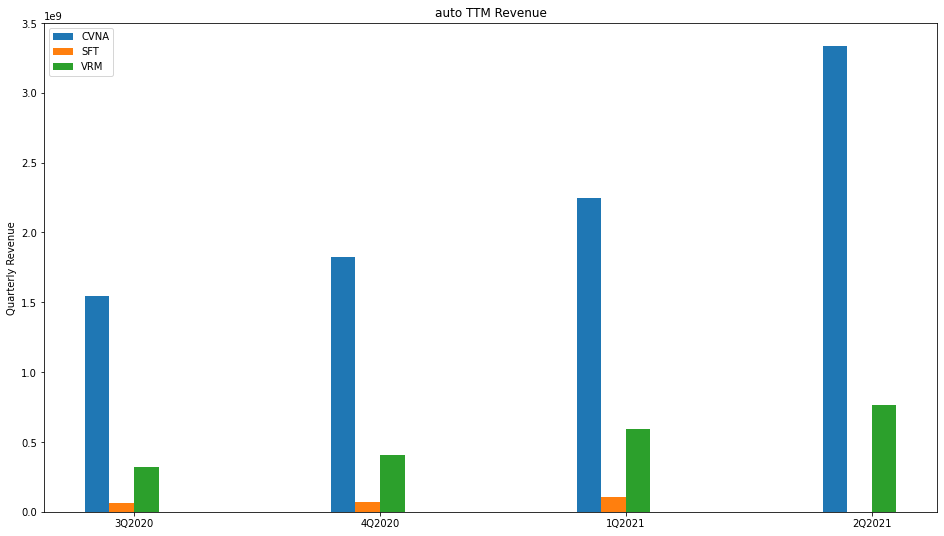

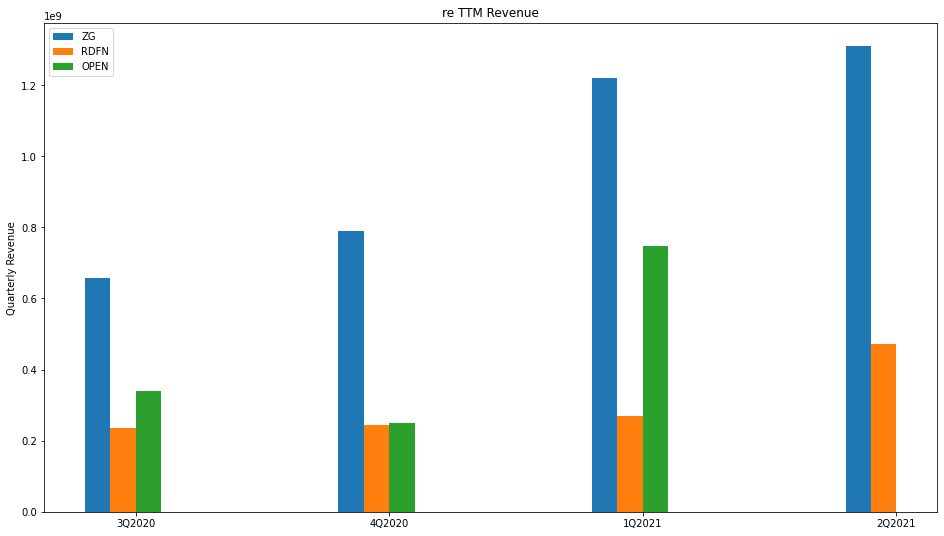

In [63]:
for sector in sectors.keys():
    raw_yfin_data = yf.Tickers(sectors[sector])
    df = pd.DataFrame()
    for stock in raw_yfin_data.symbols:
        df[stock] = raw_yfin_data.tickers[stock].quarterly_earnings['Revenue']

    plt.figure(figsize=(16,9))
    X = df.index
    X_axis = np.arange(len(X))
    width = 0.1
    n = -1 * len(df.columns) / 2 * width
    for stock in df.columns:
        plt.bar(X_axis+n,df[stock],width,label=stock)
        n += width

    plt.xticks(X_axis, X)
    plt.ylabel('Quarterly Revenue')
    plt.title(sector + ' ' + 'TTM Revenue')
    plt.legend()
    plt.show()